In [16]:
# Install necessary libraries (if not already installed)
!pip install pandas numpy scikit-learn statsmodels seaborn matplotlib

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from google.colab import files
import seaborn as sns
import matplotlib.pyplot as plt


In [21]:
# Upload the datasets manually using the file upload
uploaded = files.upload()

Saving housing_test (1).csv to housing_test (1) (23).csv
Saving housing_train.csv to housing_train (23).csv


In [22]:
def prepare_dataset(filename):
    housing = pd.read_csv(filename)

    # EDA Step 1: Data Summary
    print("Data Summary:")
    print(housing.describe())
    print(housing.info())
    print(housing.head())

    # EDA Step 2: Visualizations
    # Example: Histogram of Rooms
    sns.histplot(housing['Rooms'], kde=True)
    plt.title('Distribution of Rooms')
    plt.xlabel('Number of Rooms')
    plt.ylabel('Frequency')
    plt.show()

    # Example: Scatter plot for Distance vs Price
    if 'Price' in housing.columns:
        sns.scatterplot(data=housing, x='Distance', y='Price')
        plt.title('Distance vs Price')
        plt.xlabel('Distance')
        plt.ylabel('Price')
        plt.show()

    # Filling missing values with 0 for simplicity
    housing.fillna(0, inplace=True)

    # Converting the 'Type' and 'Method' columns to dummy variables
    type_dummies = pd.get_dummies(housing['Type'], drop_first=True)
    method_dummies = pd.get_dummies(housing['Method'], drop_first=True)

    # Adding the dummies to the dataset and dropping the original columns
    housing = pd.concat([housing, type_dummies, method_dummies], axis=1)
    housing.drop(['Type', 'Method', 'Address', 'Suburb', 'SellerG', 'CouncilArea'], axis=1, inplace=True)

    # Convert 'Price' to numeric, forcing errors to NaN, then fill NaN with 0 (for training set only)
    if 'Price' in housing.columns:
        housing['Price'] = pd.to_numeric(housing['Price'], errors='coerce').fillna(0)

    # Check and convert all other relevant columns to numeric
    numeric_columns = ['Rooms', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Distance']
    for col in numeric_columns:
        housing[col] = pd.to_numeric(housing[col], errors='coerce').fillna(0)

    # Debugging output to check types
    print("Data Types:")
    print(housing.dtypes)

    # Feature scaling for numeric variables
    scaler = MinMaxScaler()
    housing[numeric_columns] = scaler.fit_transform(housing[numeric_columns])

    return housing

In [23]:
def learn(filename):
    # Load the dataset
    df = pd.read_csv(filename)

    # Convert columns to numeric, coercing errors (non-numeric will become NaN)
    numeric_cols = ['Rooms', 'Price', 'Distance', 'Postcode',
                   'Bedroom2', 'Bathroom', 'Car', 'Landsize',
                   'BuildingArea', 'YearBuilt']  # Adjust based on your dataset
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Drop rows with NaN values
    df.dropna(inplace=True)

    # Define the independent variables and the dependent variable
    X = df[numeric_cols].drop('Price', axis=1)  # Exclude target variable
    y = df['Price']

    # Adding a constant to the model (intercept)
    X = sm.add_constant(X)

    # Fitting the model
    lm = sm.OLS(y, X).fit()

    # Returning the model and the list of columns used
    return lm, X.columns.tolist()


In [24]:
def predict(model, filename, columns):
    dataset = prepare_dataset(filename)

    # Remove 'const' from columns if present before selecting from dataset
    columns_without_const = [col for col in columns if col != 'const']

    # Prepare the test dataset
    X_test_new = dataset[columns_without_const]

    # Adding constant for prediction
    X_test_new = sm.add_constant(X_test_new)  # Now adding constant here
    preds = model.predict(X_test_new)

    # Adding predictions to the dataset
    with_predictions = dataset.copy()  # Use copy to avoid modifying the original dataset
    with_predictions['predicted'] = preds

    # Select the columns you want to keep in the final output
    additional_columns = ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt']
    output = with_predictions[['predicted'] + additional_columns]

    return output

Data Summary:
             Rooms     Distance     Postcode     Bedroom2     Bathroom  \
count  1885.000000  1885.000000  1885.000000  1466.000000  1466.000000   
mean      2.890716     8.816286  3094.767639     2.845839     1.510914   
std       0.976770     3.511990    59.355850     1.051298     0.672383   
min       1.000000     1.200000  3000.000000     0.000000     0.000000   
25%       2.000000     6.100000  3044.000000     2.000000     1.000000   
50%       3.000000     9.100000  3081.000000     3.000000     1.000000   
75%       3.000000    11.400000  3145.000000     3.000000     2.000000   
max      10.000000    15.000000  3207.000000    20.000000     5.000000   

               Car      Landsize  BuildingArea    YearBuilt  
count  1466.000000   1464.000000    825.000000   942.000000  
mean      1.587995    461.455601    151.040000  1962.015924  
std       0.924135   1203.281037    248.593274    37.006401  
min       0.000000      0.000000      1.000000  1854.000000  
25%      

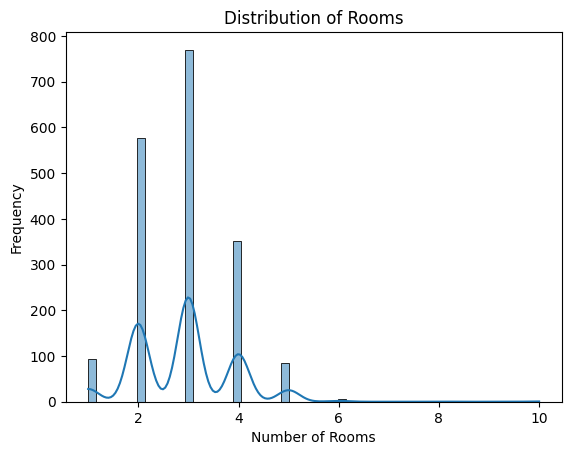

Data Types:
Rooms             int64
Distance        float64
Postcode          int64
Bedroom2        float64
Bathroom        float64
Car             float64
Landsize        float64
BuildingArea    float64
YearBuilt       float64
t                  bool
u                  bool
S                  bool
SA                 bool
SP                 bool
VB                 bool
dtype: object


In [25]:
# Load and train the model using the new datasets
model, columns = learn('housing_train.csv')

# Use the trained model to make predictions
predictions = predict(model, 'housing_test (1).csv', columns)

# Save the predictions to a CSV file
predictions.to_csv('predictions.csv', index=False)